# Predicting CLTV and Customer Repeat with Machine Learning for Shopify 

#### A Data Science Project by Benjamin N. Bellman 

![image.png](../../Images/LTV_Modelling.png)

### Project Table of Contents: 
<br> 
    
**I. INTRODUCTION \& PRELIMINARY ANALYSIS**
- 1. Project Purpose 
- 2. Loading \& Previewing Data   
- 3. Data Wrangling  
- 4. Preliminary EDA 
 
**II. DATA WRANGLING**  
- 1. Cleaning up data. 
- 2. Creating 3 separate dataframes.
- 3. Creating the final 1 year CLTV Table.

**III. EXPLORATORY DATA ANALYSIS**     
- 1. Loading an Previewing the New Table  
- 2. Exploring relationships of variables on Post First Week Spend 

**IV. PREPROCESSING AND MODELLING**
- 1. Linear Models
- 2. Classification Models


## Part 3: PreProcessing and Modelling

### Loading our Packages and DataFrame

In [1]:
## We start by importing the packages we will use.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot 

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor

from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import mean_squared_error as mse, r2_score, mean_absolute_error as mae, f1_score, fbeta_score 
from sklearn.metrics import plot_confusion_matrix,classification_report, balanced_accuracy_score, recall_score

from io import StringIO 
from IPython.display import Image  
import pydotplus
import graphviz

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
## We Load and preview our customer_cltv dataframe from the previouse chapter 
customer_cltv = pd.read_csv('.\..\..\Datasets\cleaned_data.csv',index_col=0)
customer_cltv.head()

,CustomerID,pfw_spent,fw_nb_orders,fw_nb_items,fw_total_spent,fw_used_coupon,first_order_month,fw_purchased_accessory,first_item_size,accepts_marketing,wealthy_zip,region,first_item_price_range
0,Anonymous13455,1257.80,1,1,50.0,0,6,0,M,0,0,MW,high
1,Anonymous2142,436.15,1,1,48.0,0,5,0,L,0,0,NE,high
2,Anonymous4843,1052.75,2,2,96.0,0,10,0,S,1,0,W,high
3,Anonymous11225,728.10,1,1,16.0,0,1,1,No size,0,0,MW,low
4,Anonymous540,1114.75,1,1,50.0,0,1,0,XS,0,0,W,high


## Preprocessing: 

In [3]:
## Drop some error rows (no spending on the first week)
customer_cltv = customer_cltv[customer_cltv.loc[:,'fw_total_spent'] > 0] 

## Drop all non-repeat customers
#customer_cltv_drop = customer_cltv_drop[customer_cltv.loc[:,'pfw_spent'] > 0]

<br> **Drop variables that we found to be heavily correlated with other or irrelevant through the previous step of EDA**
- **fw_nb_items** is highly correlated with fw_total_spent (c=0.94)
- **fw_nb_orders** is very unbalanced (~ 95% customers only made 1 order the first week)
- **region** was found to be insignificant based on several steps of statistical analysis
- **fw_purchased_accessory** is logically redundant with first_item_size


In [4]:
customer_cltv.drop(columns=['fw_nb_items', 'region', 'fw_nb_orders', 'fw_purchased_accessory'], inplace = True)

<br> **Modify variables based on findings from EDA**
- **first_order_month** can be modified to be 2 categories: February-June vs rest of the year
- **first_item size** can be modified to be 2 categories: Large Size and Smaller Sizes

In [5]:
## First Item Month 
customer_cltv['first_order_feb_june'] = customer_cltv['first_order_month'].apply(lambda x: x in [2, 3, 4, 5, 6])
customer_cltv['first_order_feb_june'].replace({True:1,False:0}, inplace = True)
customer_cltv.drop(columns=['first_order_month'], inplace = True)

## First Item Size: 
customer_cltv['large_size'] = customer_cltv['first_item_size'].apply(lambda x: x in ['XL','L'])
customer_cltv['large_size'].replace({True:1,False:0}, inplace = True)
customer_cltv.drop(columns=['first_item_size'], inplace = True)
customer_cltv.head()

,CustomerID,pfw_spent,fw_total_spent,fw_used_coupon,accepts_marketing,wealthy_zip,first_item_price_range,first_order_feb_june,large_size
0,Anonymous13455,1257.80,50.0,0,0,0,high,1,0
1,Anonymous2142,436.15,48.0,0,0,0,high,1,1
2,Anonymous4843,1052.75,96.0,0,1,0,high,0,0
3,Anonymous11225,728.10,16.0,0,0,0,low,0,0
4,Anonymous540,1114.75,50.0,0,0,0,high,0,0


#### We create dummy variables for our categorical variables.

In [6]:
## We create dummy variables for prize range of items. 
categorical_cols = ['first_item_price_range']
dummies_encoded = pd.get_dummies(customer_cltv[categorical_cols].astype(str),drop_first=True)
customer_cltv = pd.concat([customer_cltv,dummies_encoded], axis =1)
customer_cltv.drop(columns=['first_item_price_range'],inplace = True)
customer_cltv.head()

,CustomerID,pfw_spent,fw_total_spent,fw_used_coupon,accepts_marketing,wealthy_zip,first_order_feb_june,large_size,first_item_price_range_low,first_item_price_range_medium
0,Anonymous13455,1257.80,50.0,0,0,0,1,0,0,0
1,Anonymous2142,436.15,48.0,0,0,0,1,1,0,0
2,Anonymous4843,1052.75,96.0,0,1,0,0,0,0,0
3,Anonymous11225,728.10,16.0,0,0,0,0,0,1,0
4,Anonymous540,1114.75,50.0,0,0,0,0,0,0,0


In [7]:
## We get our feature variables and target variables
X = customer_cltv.drop(columns=['CustomerID','pfw_spent'])
y = customer_cltv['pfw_spent']
print(X.shape, y.shape)

(10590, 8) (10590,)


In [8]:
## We use a scaler to scale the feature variables which are not categorical: 
cols_to_scale = ['fw_total_spent']
scaler = StandardScaler()
scaler.fit(X[cols_to_scale])

X_scaled = scaler.transform(X[cols_to_scale])
for ind, col in enumerate(cols_to_scale):
    X[col] = X_scaled[:,ind]
X.head()

,fw_total_spent,fw_used_coupon,accepts_marketing,wealthy_zip,first_order_feb_june,large_size,first_item_price_range_low,first_item_price_range_medium
0,-0.347324,0,0,0,1,0,0,0
1,-0.389530,0,0,0,1,1,0,0
2,0.623424,0,1,0,0,0,0,0
3,-1.064833,0,0,0,0,0,1,0
4,-0.347324,0,0,0,0,0,0,0


In [9]:
## We split our data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7942, 8) (2648, 8) (7942,) (2648,)


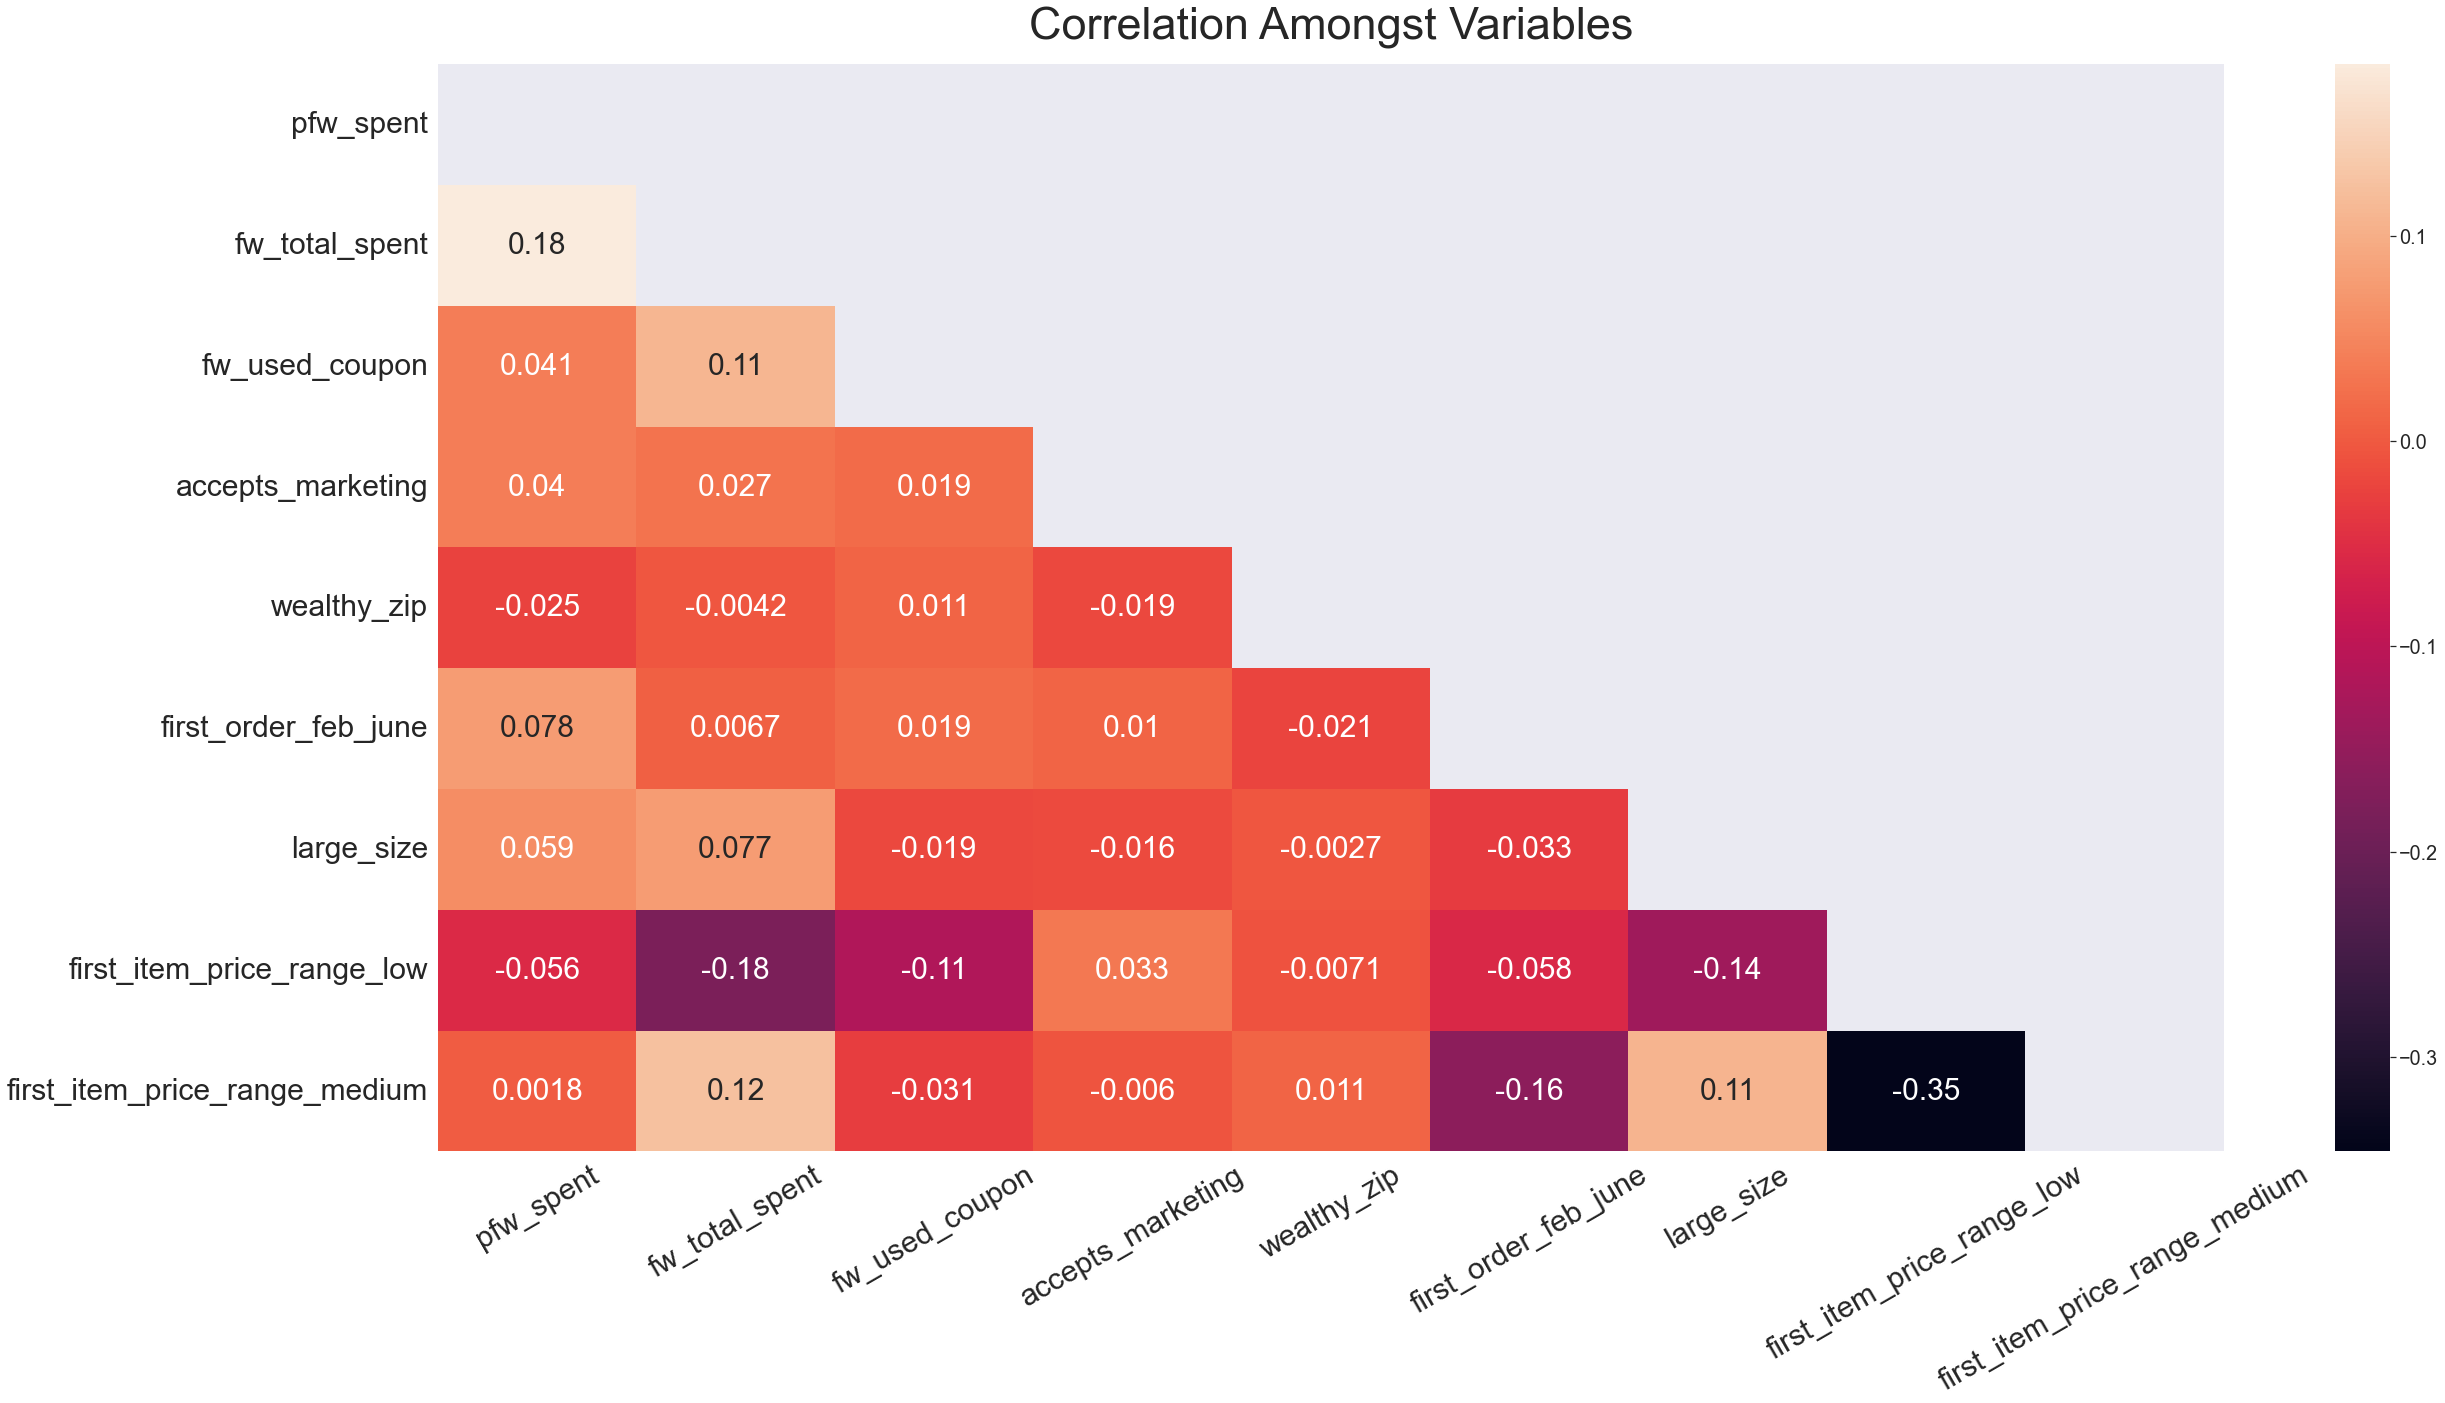

In [10]:
## Let's bring back the heatmap that we had in the EDA to see the features correlations with pfw_spent
plt.figure(figsize =(40,20))
sns.set(font_scale=1.8)
sns.heatmap(customer_cltv.corr(), annot =True,annot_kws={"size":30}, mask = np.triu(customer_cltv.corr()))
plt.xticks(fontsize = 30 ,rotation=30) 
plt.yticks(fontsize = 30) 
plt.title('Correlation Amongst Variables', fontsize = 45, pad =25)
plt.show()

## I. Linear Models: 
- Ordinary Linear Regression
- Lasso, Ridge Regression - tried but don't bring benefits compared to OLS, because we find reasonable coefficient values without applying penalization.
- Elastic Net - not tried, though we would expect the same as above.

- Decision Trees
- Random Forest
- GBM
- Light GBM
- XGboost
- Adaboost
- Neural Networks

## Multiple Linear Regression

In [11]:
## We instantiate the linear Regression model and fit to the training data. 
rModel = LinearRegression()
rModel.fit(X_train, y_train)

## We make prediction
y_pred_lin = rModel.predict(X_test)
print("R-squared on training data: ", rModel.score(X_train,y_train))

R-squared on training data:  0.04679100921030399


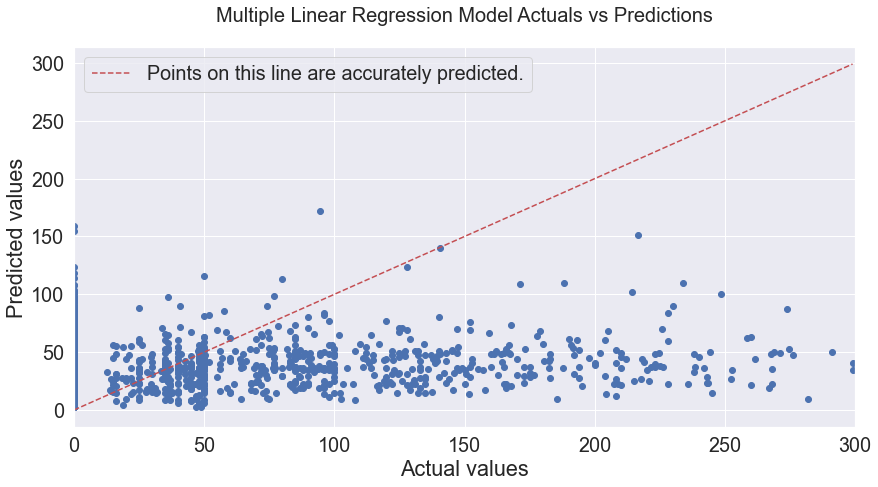

In [12]:
## We visualize the actual values vs the predicted values. 
plt.figure(figsize=(14,7))
plt.scatter(y_test, y_pred_lin)
plt.plot([x for x in range(0,300)],[x for x in range(0,300)], color='r', linestyle ='--', 
         label = 'Points on this line are accurately predicted.')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Multiple Linear Regression Model Actuals vs Predictions', pad =25, fontsize = 20)
plt.xlim(0,300)
plt.legend()
plt.show()

In [13]:
## Let's print out some metrics: 
print('Mean PFWS: ' + str(round(customer_cltv.fw_total_spent.mean(),2)))
print('R Squared - Multiple Regression: ' + str(round(r2_score(y_test,y_pred_lin),3)))
print('MSE: '+ str(round(mse(y_test,y_pred_lin),3)))
print('RMSE: ' +str(round(mse(y_test, y_pred_lin, squared =False),3)))

Mean PFWS: 66.46
R Squared - Multiple Regression: 0.038
MSE: 10788.042
RMSE: 103.866


In [14]:
## Let's get the best parameters for the Linear Regression model. 
rModel.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [15]:
## Linear Regression GridParameters:
copy_X = [True,False]
fit_intercept = [True,False]
positive = [True, False]

lr_parameter_grid = {'copy_X':copy_X  ,
                     'fit_intercept': fit_intercept,
                     'n_jobs': [-1],
                     'positive': positive}

lr_GS = GridSearchCV(estimator = rModel,
                              param_grid = lr_parameter_grid, cv =10, n_jobs =-1)

lr_GS.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False], 'n_jobs': [-1],
                         'positive': [True, False]})

In [16]:
print('Best Parameters: ' + str(lr_GS.best_params_))
print('Best Estimator: ' + str(lr_GS.best_estimator_))
print('Best Score: ' + str(lr_GS.best_score_))
print("\n")
#print('Cross Validation Results: ' + str(lr_GS.cv_results_))

Best Parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'positive': True}
Best Estimator: LinearRegression(n_jobs=-1, positive=True)
Best Score: 0.043300139970698495




In [17]:
rModel2 = LinearRegression(copy_X= True, fit_intercept= True, n_jobs= -1, positive= True)
rModel2.fit(X_train, y_train)

## We make prediction
y_pred_lin2 = rModel2.predict(X_test)
print("R-squared on training data: ", rModel2.score(X_train,y_train))
print("R-squared on testing data: ", rModel2.score(X_test,y_test))

R-squared on training data:  0.046140004581595284
R-squared on testing data:  0.03635953334782893


## Random Forest Regressor

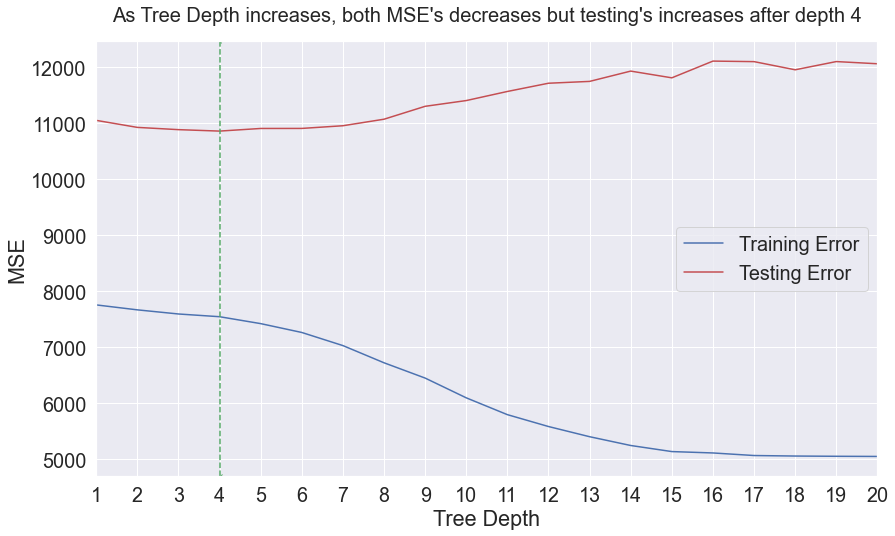

In [18]:
## Prior to making the Random Forest Regressor, let's try and find the optimal depth: 

max_depths = range(1,21)
training_error = []
for max_depth in max_depths:
    model_1 = RandomForestRegressor(max_depth = max_depth)
    model_1.fit(X,y)
    training_error.append(mse(y_train,model_1.predict(X_train)))

## We append the MSEs for each max_depth tested for the testing test.
testing_error=[]
for max_depth in max_depths:
    model_2 = RandomForestRegressor(max_depth = max_depth)
    model_2.fit(X_train,y_train)
    testing_error.append(mse(y_test,model_2.predict(X_test)))

## Since random_state is not always active, we may get a different result each time. 
## Thus, we store the testing error in errors, create an index, and start the index at 1 since we will use this to return
## the x for the MSE (y intercept) which is the lowest for the testing error. 

errors = list(enumerate(testing_error,1))

## We plot the figures. 
plt.figure(figsize=((14,8)))
plt.plot(max_depths,training_error, c ='b', label='Training Error')
plt.plot(max_depths,testing_error, c ='r',label='Testing Error')
plt.title("As Tree Depth increases, both MSE's decreases but testing's increases after depth " + 
          str(min(errors, key = lambda t: t[1])[0]), fontsize=20, pad=20)

## The axvline changes for each refesh, this code plots a line through the minimum MSE for the testing error.
plt.axvline(x=min(errors, key = lambda t: t[1])[0],c='g',marker='3',linestyle='--')
plt.annotate('Optimal Depth = ' + str(min(errors, key = lambda t: t[1])[0]),
             xy=(min(errors, key = lambda t: t[1])[0] + 0.75,14000))

## We label the axes and make our graph nice. 
plt.xlabel('Tree Depth')
plt.ylabel('MSE')
plt.xticks(range(0,21))
plt.xlim(1,20)
plt.legend()
plt.show()

In [19]:
## We instantiate a Random Forest Regressor and fit it to the training and testing data. We make predictions for y.
rfg = RandomForestRegressor(max_depth =4 , random_state = 42)
rfg.fit(X_train,y_train)
y_pred = rfg.predict(X_test)

In [20]:
## We print out our metrics. 
print("R squared for random forest regressor, on training data: ", rfg.score(X_train, y_train))
print("R squared for random forest regressor, on test data: ", rfg.score(X_test, y_test))

R squared for random forest regressor, on training data:  0.0725820842286119
R squared for random forest regressor, on test data:  0.028958023534503385


In [21]:
## We perform hyperparameter tuning with GridSearchCV where we seek to optimize the RF model. 

## We take different values for all these parameters. 
n_estimators = [10,30,50,100]
max_features = ['auto', 'sqrt']
max_depth = [2,4,6,8,10]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

## We create a grid which we will be passing in GridSearchCV
rf_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_GS = GridSearchCV(estimator = rfg,
                              param_grid = rf_grid, cv =3, n_jobs =-1, scoring ='neg_mean_squared_error')

rf_GS.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=RandomForestRegressor(max_depth=4, random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [2, 4, 6, 8, 10],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 30, 50, 100]},
             scoring='neg_mean_squared_error')

In [22]:
param_distributions = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

rf_RS = RandomizedSearchCV(rfg,  param_distributions,n_iter = 10,scoring = 'neg_mean_squared_error')
rf_RS.fit(X_train,y_train)

RandomizedSearchCV(estimator=RandomForestRegressor(max_depth=4,
                                                   random_state=42),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   scoring='neg_mean_squared_error')

In [23]:
## We get the best parameters. 
rf_GS.best_params_

{'bootstrap': True,
 'max_depth': 6,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 30}

In [24]:
rf_RS.best_params_

{'n_estimators': 2000,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 70,
 'bootstrap': True}

In [25]:
## We re-instantiate the regressor but with the best params obtained. 
rfg_best = RandomForestRegressor(bootstrap = True, max_depth =6 , max_features = 'sqrt', min_samples_leaf =4,
                            min_samples_split = 2, n_estimators = 30, random_state = 42)
rfg_best.fit(X_train,y_train)
y_pred_rf_best = rfg.predict(X_test)

In [26]:
rfg_best_2 = RandomForestRegressor(bootstrap = True, max_depth =10 , max_features = 'auto', min_samples_leaf =2,
                            min_samples_split = 10, n_estimators = 2000, random_state = 42)
rfg_best_2.fit(X_train,y_train)
y_pred_rf_best2 = rfg.predict(X_test)

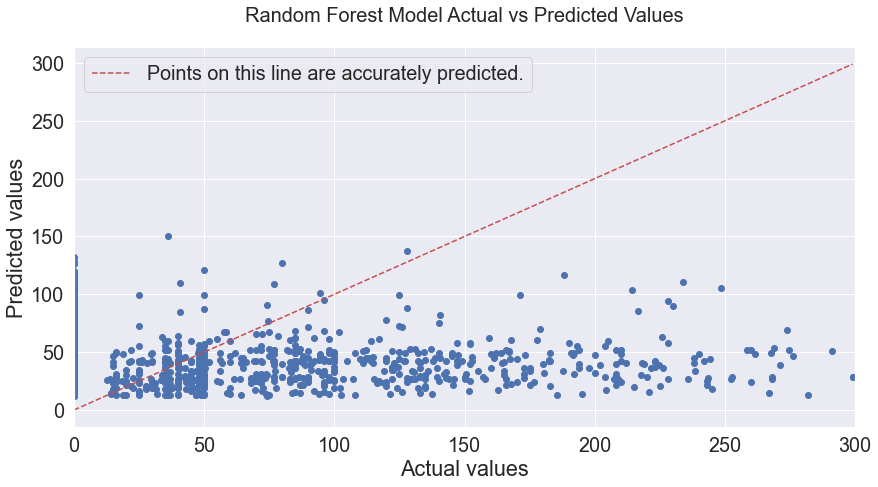

In [27]:
## We visualize the predictions. 
plt.figure(figsize=(14,7))
plt.scatter(y_test, y_pred_rf_best)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.plot([x for x in range(0,300)],[x for x in range(0,300)], color='r', linestyle='--',
        label = 'Points on this line are accurately predicted.')
plt.title('Random Forest Model Actual vs Predicted Values', pad=25, fontsize = 20)
plt.xlim(0,300)
plt.legend()
plt.show()

In [28]:
print('Mean PFWS: ' + str(round(customer_cltv.fw_total_spent.mean(),2)))
print('R Squared - Multiple Regression: ' + str(round(r2_score(y_test,y_pred_rf_best),4)))
print('MSE: '+ str(round(mse(y_test,y_pred_rf_best),3)))
print('RMSE: ' +str(round(mse(y_test, y_pred_rf_best, squared =False),3)))
print("\n")

Mean PFWS: 66.46
R Squared - Multiple Regression: 0.029
MSE: 10885.847
RMSE: 104.335




In [29]:
print('Mean PFWS: ' + str(round(customer_cltv.fw_total_spent.mean(),2)))
print('R Squared - Multiple Regression: ' + str(round(r2_score(y_test,y_pred_rf_best2),4)))
print('MSE: '+ str(round(mse(y_test,y_pred_rf_best2),3)))
print('RMSE: ' +str(round(mse(y_test, y_pred_rf_best2, squared =False),3)))
print("\n")

Mean PFWS: 66.46
R Squared - Multiple Regression: 0.029
MSE: 10885.847
RMSE: 104.335




In [30]:
## We can get the most important features
features = pd.DataFrame(rfg.feature_importances_, index = X.columns, 
                        columns=['Feature Importance']).sort_values('Feature Importance',ascending=False)
features

,Feature Importance
fw_total_spent,0.768177
first_order_feb_june,0.114879
large_size,0.039995
accepts_marketing,0.026927
first_item_price_range_medium,0.025046
fw_used_coupon,0.009326
wealthy_zip,0.007956
first_item_price_range_low,0.007695


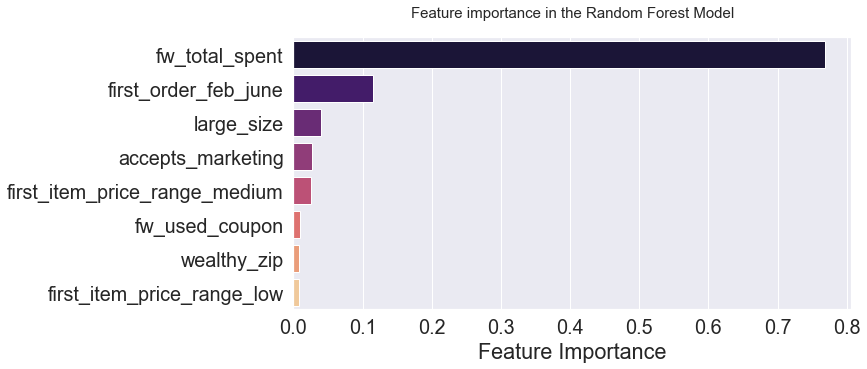

In [31]:
## We can visualize the feature importance: 
plt.figure(figsize=(10,5))
sns.color_palette("magma", as_cmap=True)
sns.barplot(y = features.index, x = features['Feature Importance'],palette='magma')
plt.title('Feature importance in the Random Forest Model', pad = 20, fontsize = 15)
plt.show()

In [32]:
## We can evaluate our two models. 
def evaluate_model(model):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    errors = abs(np.array(y_test) - y_pred)
    r2 = round(r2_score(y_test,y_pred),3)
    MSE = round(mse(y_test,y_pred),3)
    RMSE = round(mse(y_test, y_pred, squared =False),3)
    MAE = round(mae(y_test, y_pred),3)
    print('{} Performance: '.format(model))
    print('R Squared : ' + str(r2))
    print('MSE: '+ str(MSE))
    print('RMSE: ' +str(RMSE))
    print('MAE: ' +str(MAE))
    print(('Average Errors: ' + str(np.mean(errors))))
    print("\n")
    return RMSE

Reg_evaluation = evaluate_model(rModel2)
RF_Evaluation = evaluate_model(rfg_best)
print(str("RF Improvement on Simple Model: " + str(round(((RF_Evaluation-Reg_evaluation) / Reg_evaluation)*100,2))) + "%")

LinearRegression(n_jobs=-1, positive=True) Performance: 
R Squared : 0.036
MSE: 10802.872
RMSE: 103.937
MAE: 53.367
Average Errors: 53.367018222661535


RandomForestRegressor(max_depth=6, max_features='sqrt', min_samples_leaf=4,
                      n_estimators=30, random_state=42) Performance: 
R Squared : 0.029
MSE: 10889.258
RMSE: 104.352
MAE: 53.52
Average Errors: 53.51966558599653


RF Improvement on Simple Model: 0.4%


## XGBoost Regressor

In [33]:
## Using XGBoost
import xgboost as xgb
from sklearn.metrics import mean_squared_error
data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))


## https://www.datacamp.com/community/tutorials/xgboost-in-python

[09:08:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 106.117160


In [34]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=42)

[09:08:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[09:08:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[09:08:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


In [35]:
cv_results.head()


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,99.095314,3.132242,98.959234,6.151703
1,97.910611,3.326445,97.873672,6.118358
2,96.625384,3.289311,96.826533,6.211626
3,95.908859,3.293668,96.117800,6.219894
4,95.306096,3.315011,95.529742,6.215137


In [36]:
print((cv_results["test-rmse-mean"]).tail(1))

33    92.428192
Name: test-rmse-mean, dtype: float64


[09:08:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


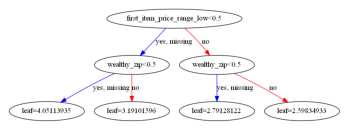

In [37]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 100]
plt.show()

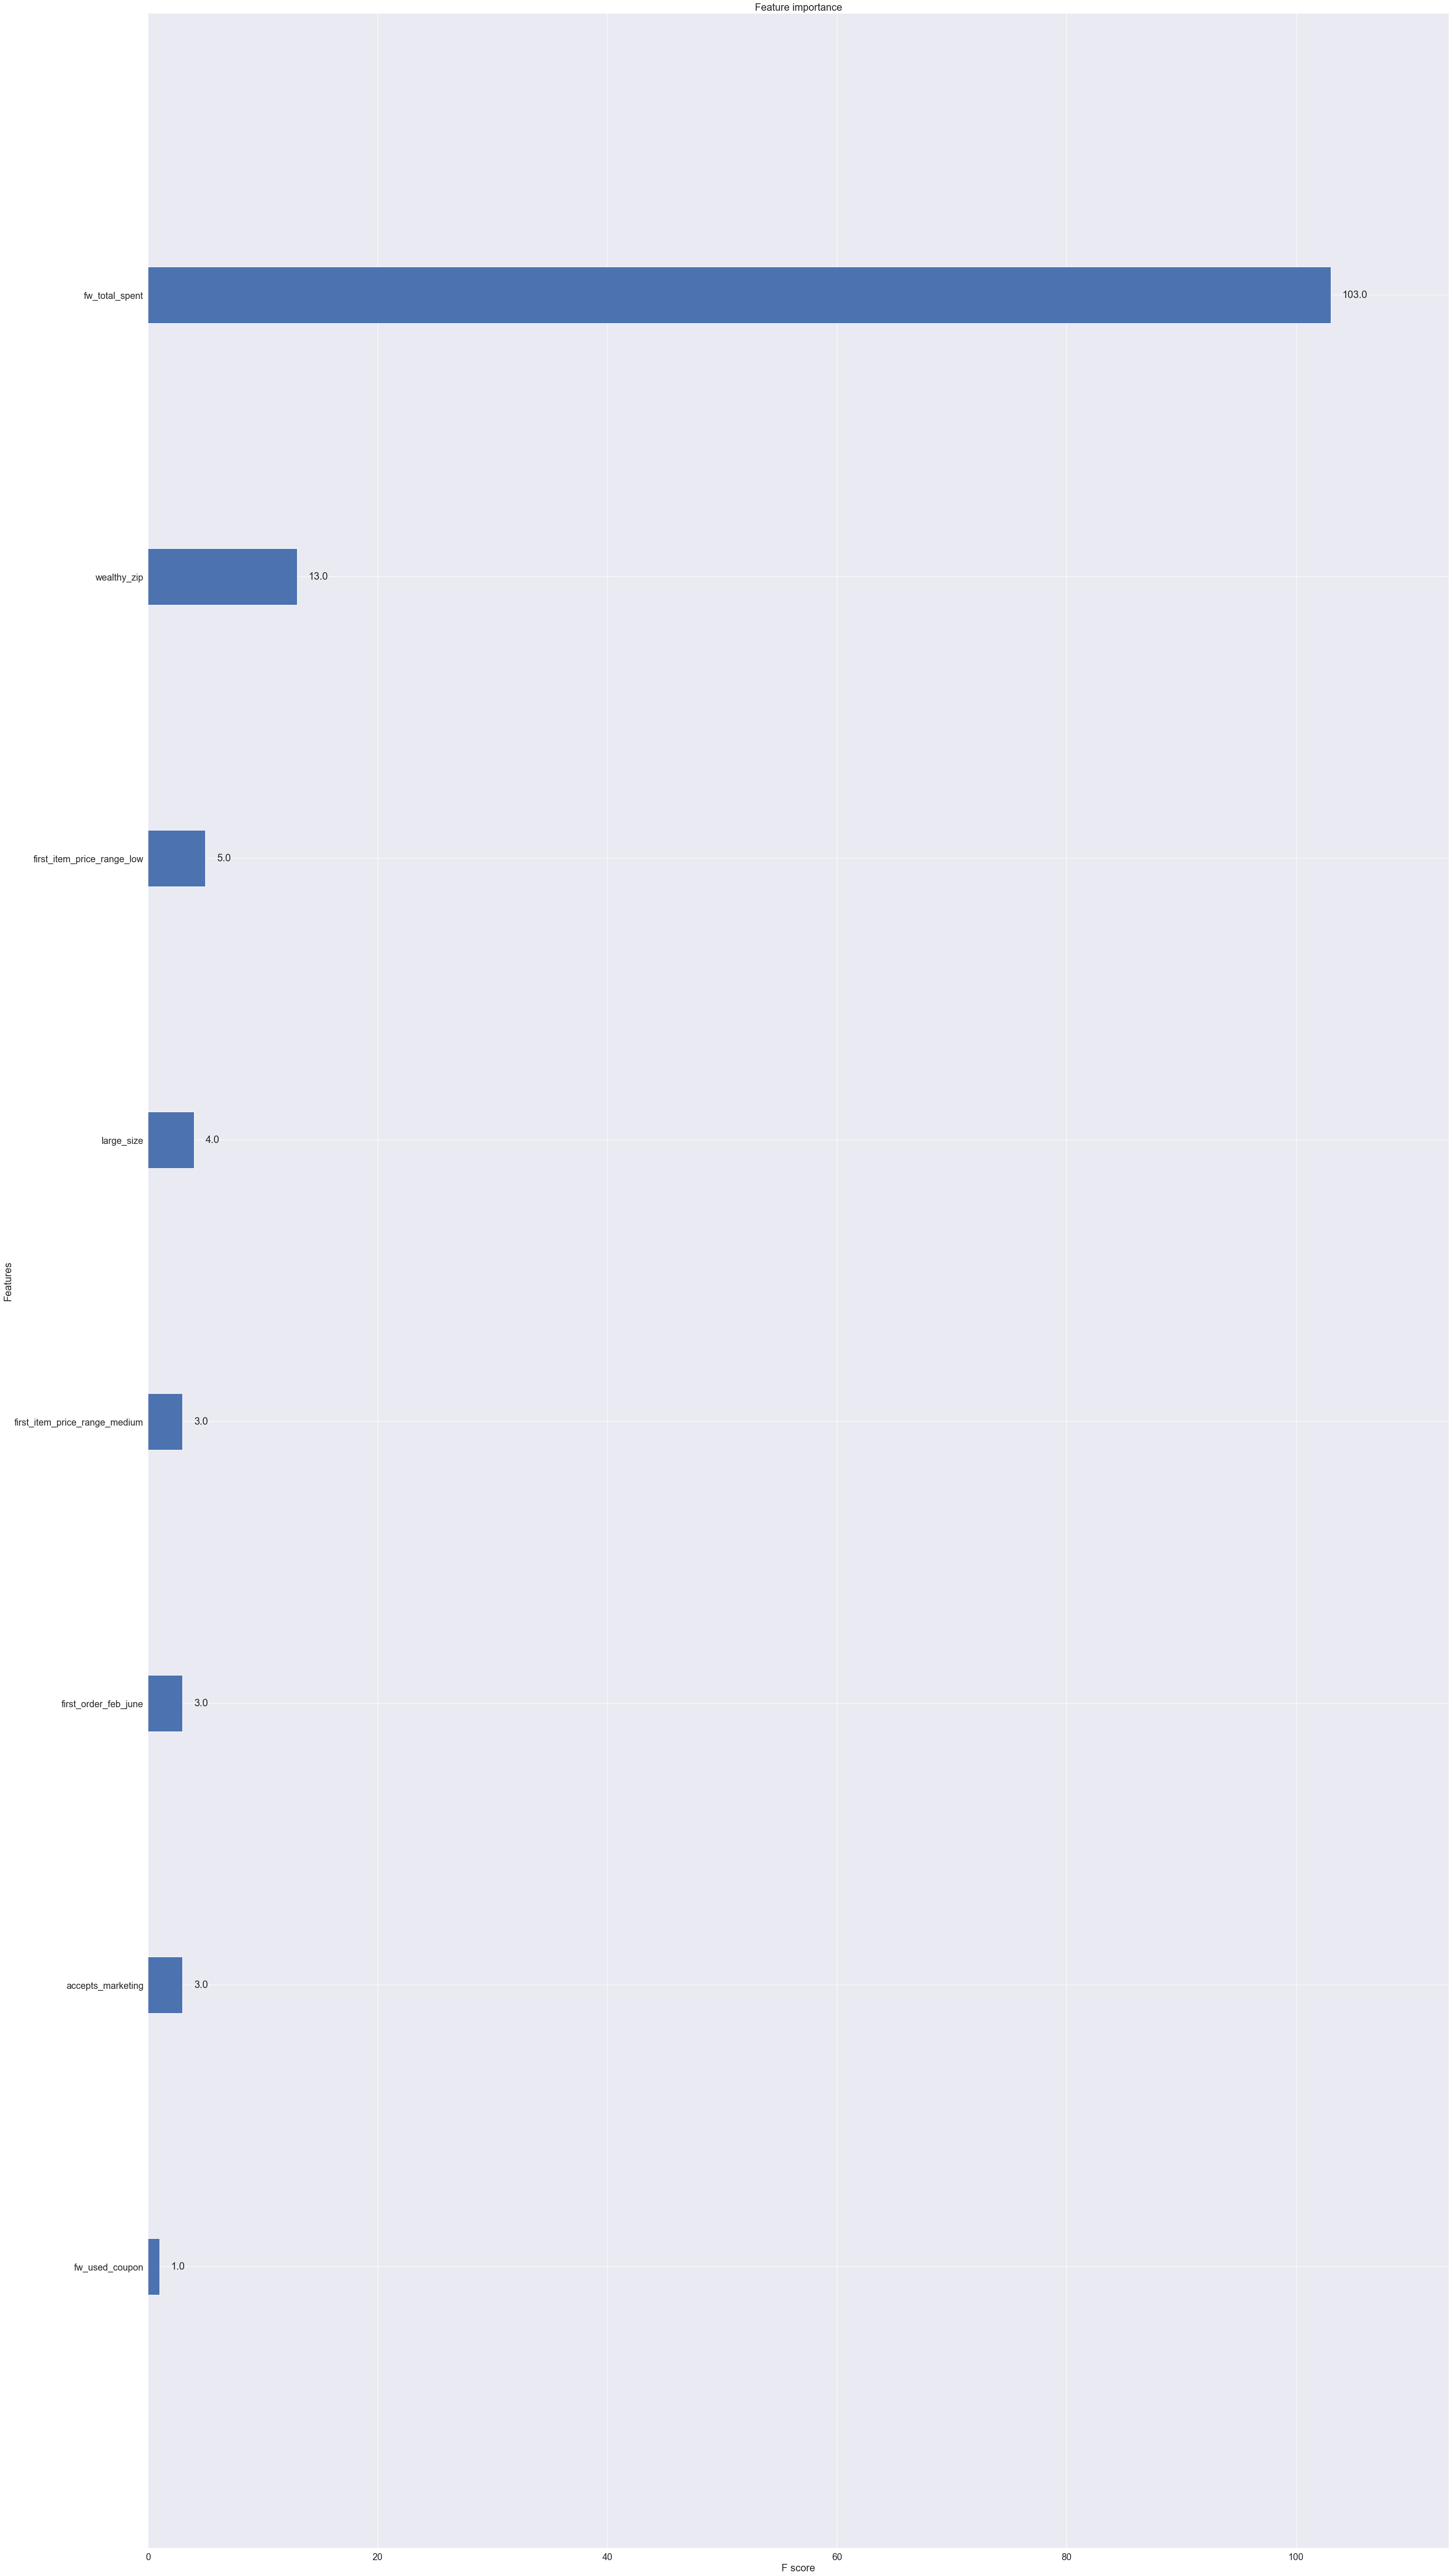

In [38]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()